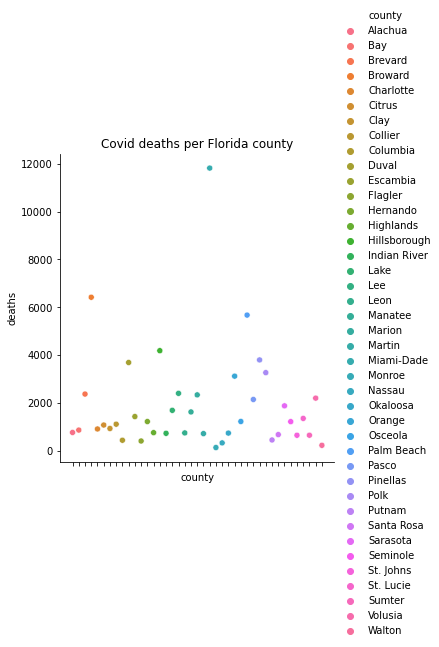

In [48]:
#finding the relationship between covid deaths, population age and educational attainment for counties in Florida 

#imports the necessary packages for the codes 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import itertools
from numpy.linalg import inv
import statsmodels.api as sm
from scipy import stats 

covid_data=pd.read_csv("us-counties-recent.csv"); #reads into file with the COVID data 

newdata=covid_data[covid_data["state"]=="Florida"]; #saves the covid data for Florida only 

agedata=pd.read_csv("cc-est2019-agesex-12.csv"); #reads into file with the age data 
newdata2=agedata[agedata["YEAR"]==12]; #saves data for the year 2019 only 
#print(newdata2)


educ_data=pd.read_csv("ACSST1Y2021.S1501-2022-10-17T192910.csv"); #reads into file with the education level data

eddat=[]; #initializes empty vector to add the dataframes columns to 

columnsdat=[i for i in range(1,len(list(educ_data.columns)),12)]; #saves the column names for the columns with the total
#county data which recurs every 12 columns for each county 

columnsdat.insert(0,0) #saves the initial column with the row names 


eddat2=educ_data[educ_data.columns[columnsdat]] #extracts and saves the columns specified above 
eddat2.columns = eddat2.columns.str.replace('County, Florida!!Total!!Estimate','') #removes the specified string so the
#column names only include the name of the county 
#print(eddat2)

#since the education data for lacks a few counties. This should go through and remove these missing counties from the 
#covid data 
#print(list(newdata[newdata['county']=="Baker"].index))

for j in newdata["county"]: #loops through the counties in the data set 
    k=j+' ' #adds a space to the string because this is how it appears in the education data set    
    b=list(newdata[newdata['county']==j].index) #finds the index of the county name 
    if k not in list(eddat2.columns): #if the county name is not in the list of county names in the education data set 
                                      #then it is removed by its index
        newdata=newdata.drop(b)

#print(newdata)
#print(len(newdata))
#print(newdata.iloc[(1230-41):1231,5])

cumuldeaths=newdata.iloc[(1230-41):1231,5] #finds the final cumulative deaths for the data using the length of the data
#as indices 

# print(cumuldeaths)


#plots the data 
sns.relplot(data=cumuldeaths, x=newdata.iloc[(1230-41):1231,1], y=cumuldeaths, hue=newdata.iloc[(1230-41):1231,1]).set(xticklabels=[],title='Covid deaths per Florida county')


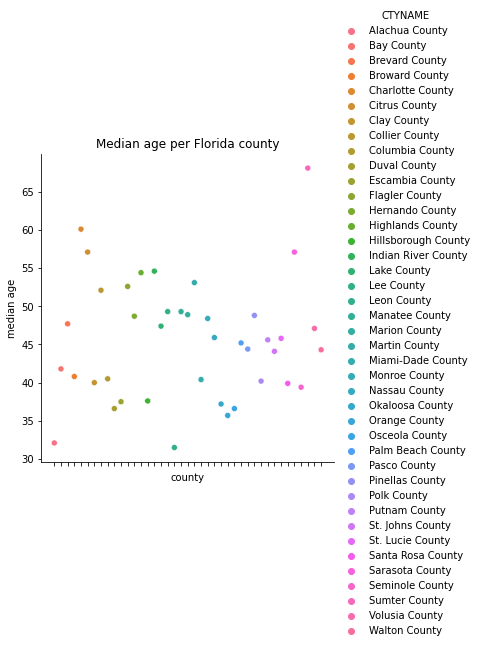

In [49]:
#median age used for the sake of plotting the data. gives an idea of the counties with older population  

agedata2=[]; #initializes empty vector to add the dataframe columns to


columnsdat2=[i for i in range(39,len(list(newdata2.columns)),3)]; #saves the column names for the columns with the 
#desired age ranges which recurs every 3 columns 

columnsdat2.insert(0,9) #adds additional desired columns 
columnsdat2.insert(0,6)
columnsdat2.insert(0,4)


agedata2=newdata2[newdata2.columns[columnsdat2]] #extracts and saves the columns specified above 

#similar to the first cell, any county name that is not in the education data set is removed from the age data set 
for j in agedata2["CTYNAME"]:
    k=j.replace('County','')  
    b=list(agedata2[agedata2['CTYNAME']==j].index)
    if k not in list(eddat2.columns):
        agedata2=agedata2.drop(b)
# print(agedata2)

#plots the data 
sns.relplot(data=agedata2["MEDIAN_AGE_TOT"], x=agedata2["CTYNAME"], y=agedata2["MEDIAN_AGE_TOT"], hue=agedata2["CTYNAME"]).set(xticklabels=[],title='Median age per Florida county',xlabel="county",ylabel="median age")



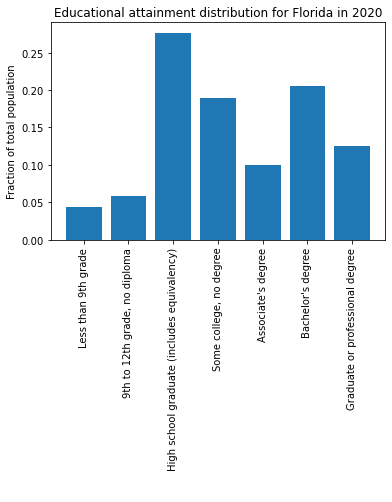

In [50]:
#Education data - looking at the 5 categories 
#normalized to the total population 
#looking at educational attainment for the population 25 and over 

tot_pop=int(eddat2.iloc[6,-1].replace(",","")); #total population in the state. converts from string to integer 
fracpop=[int(i.replace(",",""))/tot_pop for i in eddat2.iloc[7:14,-1]] #for each education level, finds the fraction of 
#the population 
# print(fracpop)

#plots the fraction of the population that has obtained each education level 
plt.bar(eddat2.iloc[7:14,0], fracpop)
plt.xticks(rotation=90)
plt.ylabel("Fraction of total population")
plt.title("Educational attainment distribution for Florida in 2020")


#finds the counties with the highest and lowest deaths 
maxdeath=np.max(newdata["deaths"])

mindeath=np.min(cumuldeaths)   
# print(mindeath)

max_ind=newdata[newdata['deaths']==maxdeath].index #finds the indices at which the max and min death occur
min_ind=newdata[newdata['deaths']==mindeath].index
countymax=newdata.loc[max_ind[-1]].at["county"] #saves the counties at these indices 
countymin=newdata.loc[min_ind[-1]].at["county"]
   
# print(eddat2[countymax+' '])
# print(eddat2[countymin+' '])

#saves the data for the two counties at each education level as a fraction of the county population 
md_eddat=[int(eddat2[countymax+' '][i].replace(",",""))/int(eddat2[countymax+' '][6].replace(",","")) for i in range(7,14)]
# print(md_eddat)
mon_eddat=[int(eddat2[countymin+' '][i].replace(",",""))/int(eddat2[countymin+' '][6].replace(",","")) for i in range(7,14)]
# print(sum(mon_eddat))

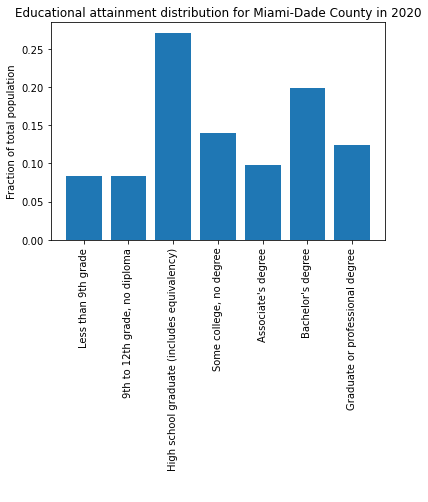

In [51]:
#plots the education levels for Miami dade (county with max deaths)
plt.bar(eddat2.iloc[7:14,0],md_eddat,)
plt.xticks(rotation=90)
plt.ylabel("Fraction of total population")
plt.title("Educational attainment distribution for Miami-Dade County in 2020")

plt.savefig('MiamiDade_educ.png',bbox_inches='tight')

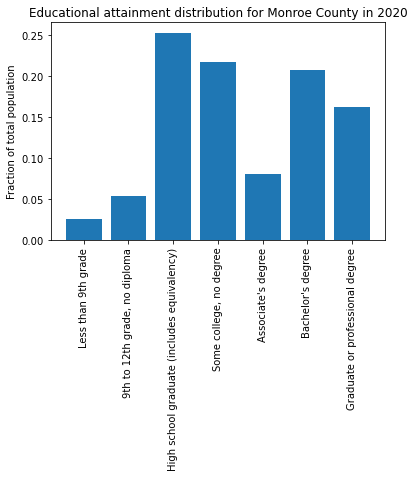

In [52]:
#plots the education levels for Monroe (county with least deaths)
plt.bar(eddat2.iloc[7:14,0], mon_eddat)
plt.xticks(rotation=90)
plt.ylabel("Fraction of total population")
plt.title("Educational attainment distribution for Monroe County in 2020")

plt.savefig('Monroe_educ.png',bbox_inches='tight')

Text(0.5, 1.0, 'Null distribution of U1 for n=7')

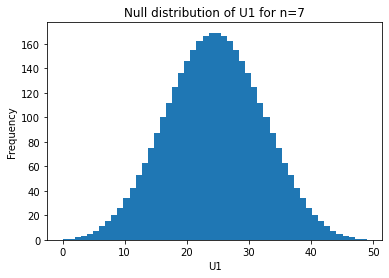

In [53]:
#since the Florida edducation data is not normally distributed. It is assumed that these samples do not come from a 
#normal distribution so a U test is used to determine if there is a difference in the educational level of these two 
#counties

r=len(md_eddat); #number of samples in each group equal to the length of the data for miami dade county 
x=[i for i in itertools.product(["J","B"],repeat=(r*2))]; # for the two groups J and B, finds all possible combinations
#allowing for repeats 
#print(x)

x2=[''.join(x[i]) for i in range(0,len(x))]; #joins the letter combinations to form a string of each combination
# print (x2)

#it returns combinations where the number of letter repeats is greater than r but for this there can only be r repeats
#per combination so this returns a list of the combinations that only have r repeats of each letter 
y3=[x2[i] for i in range(0,len(x2)) if x2[i].count('J')==r and x2[i].count('B')==r ]; 

allcounts=[]; #initializes empty vector to add in the number of wins for each combination 

for i in range(0,len(y3)): #for loop iterates over the list of combinations     
    counts=[abs(x-len(y3[i])) for x in range(0,len(y3[i])) if y3[i][x]=='J']; #for each combination if the letter is a J
    #it returns the absolute value of the index - the length of the combination to return the rank of the J
    allcounts.append((sum(counts)-((r)*((r)+1))/2)); #finds the u value for each combination
    #using R1(sum of ranks) - n(n+1)/2 and adds it to a list 
    

plt.hist(allcounts,bins=50); #plots the u values 

#adds labels to the plots

plt.xlabel('U1')
plt.ylabel('Frequency')
plt.title('Null distribution of U1 for n='+str(len(md_eddat)))

In [54]:
#finding whether the following vectors come from the same distribution using the u statistic 

#vectors with the sample values 



u=[]; #initializing the empty list to place the wins inside 

for i in range(0,len(md_eddat)): #for loop iterating over the length of miami dade age data 
    wins=[1 for x in range(0,len(md_eddat)) if mon_eddat[i]>md_eddat[x]]; #loops over all elements of the county education level
    #data. if the element in monroe is greater than the element in miami dade then a 1 is added to the list 
    u.append(sum(wins)); # adds the number of wins for each element in monroe to the list u 

u1=sum(u) #sums up the total number of wins for moroe over miami dade to get u1 
u2=(len(md_eddat)*len(mon_eddat))-sum(u) #finds u2 using the formula u1+u2= n1*n2


#for the two sided p value, finds all u values less than the smaller u value (of u1 and u2) and all u values greater
#than the larger u value (of u1 and u2). Divided by the total number of U values in the distribution 

if u1<u2: 
    p=(len([x for x in allcounts if x<=u1])+len([x for x in allcounts if x>=u2]))/len(allcounts)
else:
    p=(len([x for x in allcounts if x>=u1])+len([x for x in allcounts if x<=u2]))/len(allcounts)

print("U1 is",u1,'and U2 is',u2) 
print("the likelihood of monroe and miami dade education level being from the same distribution is",p)

print("U and p values from the stats package. U1=",stats.mannwhitneyu(mon_eddat,md_eddat)[0],"U2=",stats.mannwhitneyu(md_eddat,mon_eddat)[0],"and p is",stats.mannwhitneyu(mon_eddat,md_eddat)[1])



U1 is 23 and U2 is 26
the likelihood of monroe and miami dade education level being from the same distribution is 0.9015151515151515
U and p values from the stats package. U1= 23.0 U2= 26.0 and p is 0.9015151515151516


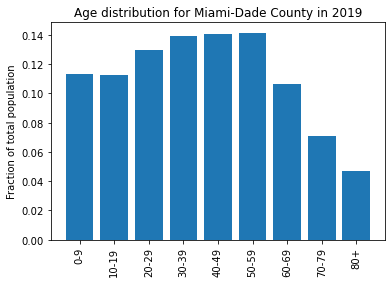

In [32]:
# print(list(newdata2[newdata2['CTYNAME']=="Miami-Dade County"].index))
# print(agedata2[agedata2['CTYNAME']=="Miami-Dade County"])

#combines 2 age groups for each county and saves them as a fraction of the total county population to have 9 different 
#age groups in total 
mdage=[(agedata2[agedata2['CTYNAME']=="Miami-Dade County"].iloc[0,i]+agedata2[agedata2['CTYNAME']=="Miami-Dade County"].iloc[0,i+1])/agedata2[agedata2['CTYNAME']=="Miami-Dade County"].iloc[0,1] for i in range(3,len(list(agedata2[agedata2['CTYNAME']=="Miami-Dade County"].columns))-2,2)]
# print(mdage)
#print(len(mdage))
monage= [(agedata2[agedata2['CTYNAME']=="Monroe County"].iloc[0,i]+agedata2[agedata2['CTYNAME']=="Monroe County"].iloc[0,i+1])/agedata2[agedata2['CTYNAME']=="Monroe County"].iloc[0,1] for i in range(3,len(list(agedata2[agedata2['CTYNAME']=="Monroe County"].columns))-2,2)]
# print(sum(monage))

#adds the age labels to a list 
agelabels=["0-9","10-19","20-29","30-39","40-49","50-59","60-69","70-79","80+"]

#plots the age distribution for Miami Dade using the age data and the age labels 
plt.bar(agelabels,mdage)
plt.xticks(rotation=90)
plt.ylabel("Fraction of total population")
plt.title("Age distribution for Miami-Dade County in 2019")

plt.savefig('Miamidade_age.png',bbox_inches='tight')

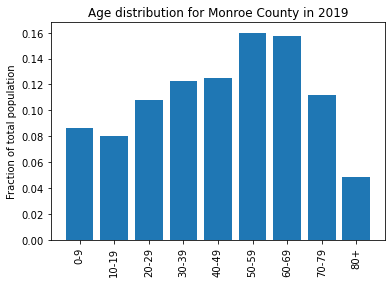

In [33]:
#plots the age distribution for Monroe using the age data and the age labels 

plt.bar(agelabels,monage)
plt.xticks(rotation=90)
plt.ylabel("Fraction of total population")
plt.title("Age distribution for Monroe County in 2019")

plt.savefig('Monroe_age.png',bbox_inches='tight')

Text(0.5, 1.0, 'Null distribution of U1 for n= 9')

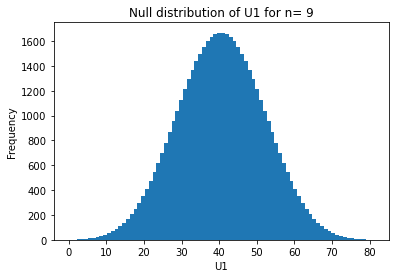

In [9]:
r=len(mdage); #number of samples in each group
x=[i for i in itertools.product(["J","B"],repeat=(r*2))]; # for the two groups J and B, finds all possible combinations
#allowing for repeats
#print(x)

x2=[''.join(x[i]) for i in range(0,len(x))]; #joins the letter combinations to form a string of each combination
# print (x2)

#it returns combinations where the number of letter repeats is greater than r but for this there can only be r repeats
#per combination so this returns a list of the combinations that only have r repeats of each letter 
y3=[x2[i] for i in range(0,len(x2)) if x2[i].count('J')==r and x2[i].count('B')==r ]; 

allcounts=[]; #initializes empty vector to add in the number of wins for each combination 

for i in range(0,len(y3)): #for loop iterates over the list of combinations     
    counts=[abs(x-len(y3[i])) for x in range(0,len(y3[i])) if y3[i][x]=='J']; #for each combination if the letter is a J
    #it returns the absolute value of the index - the length of the combination to return the rank of the J
    allcounts.append((sum(counts)-((r)*((r)+1))/2)); #finds the u value for each combination
    #using R1(sum of ranks) - n(n+1)/2 and adds it to a list 
    

plt.hist(allcounts,bins=80); #plots the u values 

#adds labels to the plots

plt.xlabel('U1')
plt.ylabel('Frequency')
plt.title('Null distribution of U1 for n= '+str(len(mdage)))

In [55]:
u=[]; #initializing the empty list to place the wins inside 

for i in range(0,len(mdage)): #for loop iterating over the length of miami dade age data 
    wins=[1 for x in range(0,len(monage)) if monage[i]>mdage[x]]; #loops over all elements of the age data. if the 
    #element in monroe is greater than the element in miami dade then a 1 is added to the list 
    u.append(sum(wins)); # adds the number of wins for each element in monroe to the list u 

u1=sum(u) #sums up the total number of wins for monroe over miami dade to get u1 
u2=(len(mdage)*len(monage))-sum(u) #finds u2 using the formula u1+u2= n1*n2


#for the two sided p value, finds all u values less than the smaller u value (of u1 and u2) and all u values greater
#than the larger u value (of u1 and u2). Divided by the total number of U values in the distribution 

if u1<u2: 
    p=(len([x for x in allcounts if x<=u1])+len([x for x in allcounts if x>=u2]))/len(allcounts)
else:
    p=(len([x for x in allcounts if x>=u1])+len([x for x in allcounts if x<=u2]))/len(allcounts)

print("U1 is",u1,'and U2 is',u2) 
print("the likelihood of monroe and miami dade age data being from the same distribution is",p)

print("U and p values from the stats package. U1=",stats.mannwhitneyu(monage,mdage)[0],"U2=",stats.mannwhitneyu(mdage,monage)[0],"and p is",stats.mannwhitneyu(mdage,monage)[1])


U1 is 39 and U2 is 42
the likelihood of monroe and miami dade age data being from the same distribution is 0.9865967365967366
U and p values from the stats package. U1= 39.0 U2= 42.0 and p is 0.9296365245070707


age slope  -629.8717948717955 education slope  1154.7773279352234 interaction slope  -1358.9439946018897 intercept  1541.5384615384614
                            OLS Regression Results                            
Dep. Variable:                 deaths   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     1.967
Date:                Tue, 25 Oct 2022   Prob (F-statistic):              0.136
Time:                        11:46:47   Log-Likelihood:                -369.04
No. Observations:                  41   AIC:                             746.1
Df Residuals:                      37   BIC:                             752.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.9

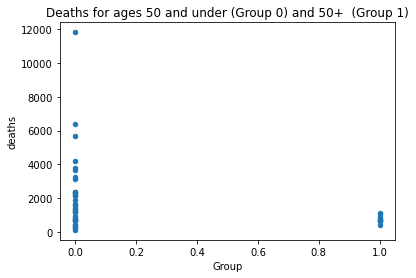

In [42]:
#finding the relationship between population age, education attainment and covid deaths taking interaction effects 
#into consideration

# print(len(list(eddat2.columns))-1)

totpop=[int(i.replace(",","")) for i in eddat2.iloc[6,1:len(list(eddat2.columns))-1]]; #lists the total population for 
#each county

#lists the population for each county with a bachelors degree or higher 
bachdata=[int(i.replace(",","")) for i in eddat2.iloc[15,1:len(list(eddat2.columns))-1]]
# print(bachdata)

bachperc=[1 if (bachdata[i]/totpop[i])>0.305 else 0 for i in range(0,len(bachdata))] #30.5% of the florida population
#has a bachelors degree or higher. so adds a 1 for every county that has above that precentage i.e has a higher than
#average educational attainment 

deathdat=[]; #initializes a vector to make a dataframe
deathdat=pd.DataFrame(deathdat)
deathdat["deaths"]=newdata.iloc[(1230-41):1231,5] #adds the deaths for each county 
deathdat["age"]=[1 if x>50 else 0 for x in agedata2["MEDIAN_AGE_TOT"]] #adds a column of 1s and 0s where 1 is assigned
#if the median age of the county is above 50. 50 is the start of the age group where more covid deaths are seen 
deathdat["education"]=bachperc
# print(deathdat)

#finds the slopes for age, education and their interaction 
X=np.c_[np.ones(len(deathdat)),deathdat["age"],deathdat["education"],np.multiply(deathdat["age"],deathdat["education"])]
tmp=inv(np.matmul(np.transpose(X),X))
intercept,slope1,slope2,slope3=tmp @np.transpose(X) @ deathdat["deaths"]

print("age slope ",slope1,"education slope ", slope2,"interaction slope ", slope3, "intercept ",intercept)

import statsmodels.api as sm
# model=sm.OLS(cardata["mpg"],sm.add_constant(cardata[["Group1","Group2"]])).fit()

#plots the data for ages above and below 50 
deathdat.plot(x="age",y="deaths",kind="scatter")
plt.xlabel("Group")
plt.title('Deaths for ages 50 and under (Group 0) and 50+  (Group 1)')
plt.savefig('agedeaths.png',bbox_inches='tight')

model=sm.OLS(deathdat["deaths"],X).fit()
print(model.summary())

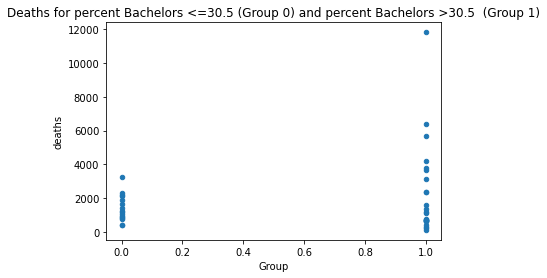

In [43]:
#plots the data for percent of population with bachelors above and below 30.5 percent 

deathdat.plot(x="education",y="deaths",kind="scatter")
plt.xlabel("Group")
plt.title('Deaths for percent Bachelors <=30.5 (Group 0) and percent Bachelors >30.5  (Group 1)')
plt.savefig('educdeaths.png',bbox_inches='tight')